# Time series forecasting Bitcoin Price 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

In [151]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Download the data
The data is downloaded from [finance](https://finance.yahoo.com/quote/BTC-USD/history/) and preprocessed to keep only closing prices and dates.

In [152]:
!wget https://raw.githubusercontent.com/kishan5111/Deep_Learning_Vault/main/notebooks/data/bitcoin_prices.csv

--2023-09-21 11:27:01--  https://raw.githubusercontent.com/kishan5111/Deep_Learning_Vault/main/notebooks/data/bitcoin_prices.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82392 (80K) [text/plain]
Saving to: ‘bitcoin_prices.csv.1’

bitcoin_prices.csv. 100%[===================>]  80.46K  --.-KB/s    in 0.02s   

2023-09-21 11:27:02 (3.59 MB/s) - ‘bitcoin_prices.csv.1’ saved [82392/82392]



In [153]:
# let's read in Bitcoin data and parse the data
df = pd.read_csv("/content/bitcoin_prices.csv",
                  parse_dates=['Date'],
                 index_col=['Date']) #parse the date column and tell pandas column 1 is a datetime
df.head(3)

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483


In [154]:
df.tail(3)

,Price
Date,
2023-09-06,25753.236328
2023-09-07,26240.195313
2023-09-08,26233.162109


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3630 entries, 2013-10-01 to 2023-09-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3630 non-null   float64
dtypes: float64(1)
memory usage: 56.7 KB


In [156]:
len(df)

3630

In [157]:
bitcoin_prices = df

We've collected the historical price of Bitcoin for the past ~8years but there's 3279 samples.


Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> **🔑Note**: The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

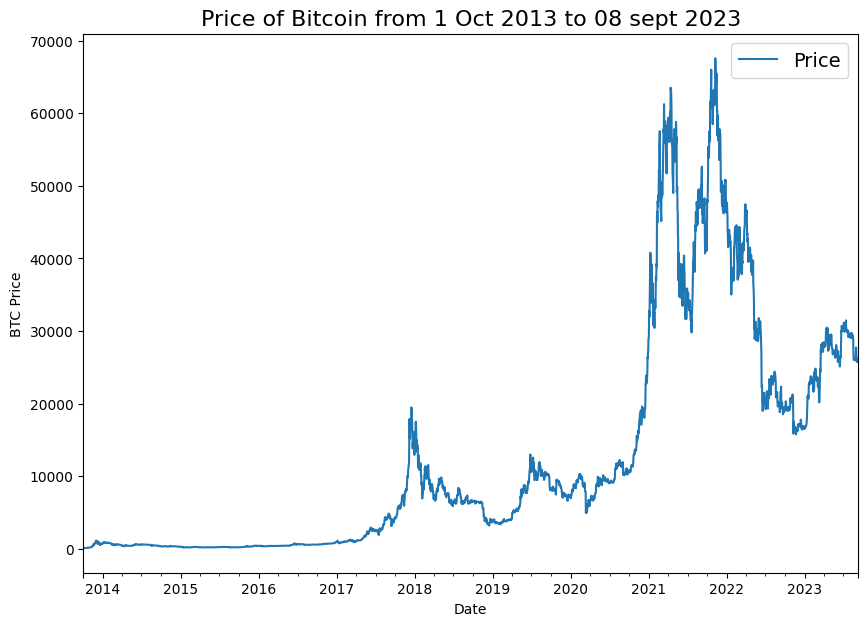

In [158]:
bitcoin_prices.plot(figsize=(10,7))
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 08 sept 2023", fontsize=16)
plt.legend(fontsize=14);

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
 * Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.

## Create train and test sets with time series data

In [159]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [160]:
# Normalize the prices
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
norm_price = prices.reshape(-1, 1)
norm_price = scaler.fit_transform(norm_price)
norm_price[:10], prices[:10]

(array([[0.0002234 ],
        [0.00025008],
        [0.        ],
        [0.00014957],
        [0.00018906],
        [0.00017893],
        [0.00019583],
        [0.00021418],
        [0.00022924],
        [0.00025759]]),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [161]:
# Splitting the data into train and test split
split_size = int(0.8 * len(norm_price)) #80%train 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], norm_price[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], norm_price[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2904, 2904, 726, 726)

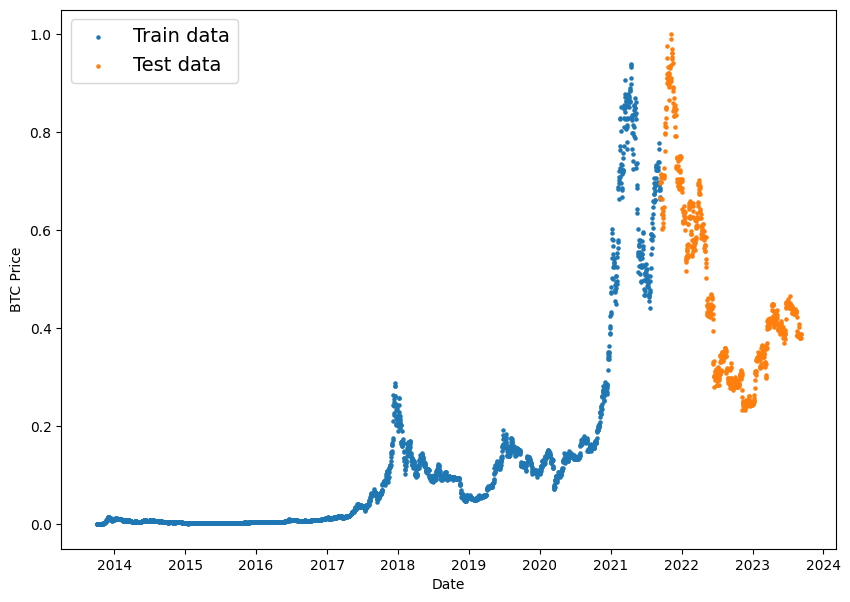

In [162]:
# plot train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Creating plotting function

In [163]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps: array of timestep values
  values: array of values across time
  format: style of plot, default "."
  start: where to start the plot (setting a value index from start of timesteps)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values, default None
  """
  # PLot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) #make label bigger
  plt.grid(True)

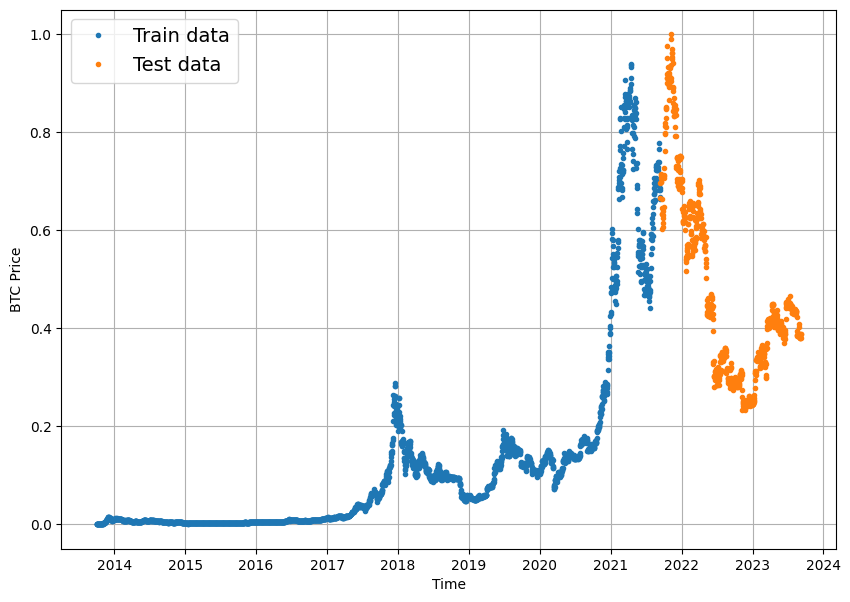

In [164]:
# Test plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")


## Format Data : Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [165]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to  make the prediction

In [166]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

To speed things up, we'll leverage `tf.timeseries_dataset_from_array
`

Our function will do below:

```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7 ,8]]
```


In [167]:
def make_windows_horizon(x, horizon=HORIZON, window_size=WINDOW_SIZE):
  """
  Returns windows and horizons
  """
  labels = x[WINDOW_SIZE:]
  data= x[:]
  windowed_data = tf.keras.utils.timeseries_dataset_from_array(data=data,
                                                         targets=labels,
                                                         sequence_length=window_size)
     # Initialize empty lists to collect windows and labels
  windows = []
  all_labels = []

  for data in windowed_data:
        batch_windows, batch_labels = data
        windows.extend(batch_windows.numpy())
        all_labels.extend(batch_labels.numpy())

  # Convert lists to NumPy arrays
  windows = np.array(windows)
  all_labels = np.array(all_labels)

  return windows, all_labels

In [168]:
full_windows, full_labels = make_windows_horizon(tf.squeeze(norm_price))
len(full_windows), len(full_labels)

(3623, 3623)

In [169]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [0.0002234  0.00025008 0.         0.00014957 0.00018906 0.00017893
 0.00019583] -> Label: 0.0002141794581993052
Window: [0.00025008 0.         0.00014957 0.00018906 0.00017893 0.00019583
 0.00021418] -> Label: 0.0002292406271591455
Window: [0.         0.00014957 0.00018906 0.00017893 0.00019583 0.00021418
 0.00022924] -> Label: 0.00025758645869285407


## Turning windows into train and test sets

In [170]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels in train and test splits.
  """
  split_size = int((len(windows)) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [171]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2898, 725, 2898, 725)

In [172]:
# Modelling checkpoints
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name ),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model(window = 7, horizon=1)
* Normalized data
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128
* 100 epochs





In [173]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer="adam",
                metrics=["mae", "mse"])

# 3. fit the model
model_1.fit(x=train_windows, y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data= (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [174]:
# Evaluate model on test data
model_1.evaluate(test_windows,test_labels )

23/23 [==============================] - 0s 2ms/step - loss: 0.0103 - mae: 0.0103 - mse: 2.5839e-04


[0.010289900936186314, 0.010289900936186314, 0.0002583886089269072]

In [175]:
# load in saved best performance model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 3ms/step - loss: 0.0103 - mae: 0.0103 - mse: 2.6072e-04


[0.01025888416916132, 0.01025888416916132, 0.00026071572210639715]

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

we're predicting a number, so that means we have a form of regression problem.

Because we're working on a regrression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean absolute error
* MSE - Mean squared error
* RMSE - Root mean squared error
* MAPE/sMAPE - (symmetric) Mean absolute percentage error
* MASE -  Scaled Mean absolute error

For all the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts(y_pred) compare against the actual values (y_true or ground truth values)?**

In [176]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) #seasonality is 1 day.. hence shift of 1

  return mae / mae_naive_no_season

In [177]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype(for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred , dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae":mae.numpy(),
           "mape": mape.numpy(),
          "mase": mase.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
         }

In [178]:
def evaluate_preds_normalized(y_true, y_pred, scaler):
    """
    Calculate various evaluation metrics for regression predictions on normalized data
    and convert them to non-normalized metrics using a scaler.

    Args:
        y_true (tf.Tensor or np.ndarray): True target values.
        y_pred (tf.Tensor): Predicted target values.
        scaler: Scaler object (e.g., StandardScaler, MinMaxScaler) used for normalization.

    Returns:
        dict: A dictionary containing non-normalized evaluation metrics.
    """
    if y_true.ndim == 1:
      y_true = tf.expand_dims(y_true, axis=1)
    if y_pred.ndim == 1:
      y_pred = tf.expand_dims(y_pred, axis=1)

    # Convert normalized predictions to non-normalized values using the scaler
    y_true_non_normalized = scaler.inverse_transform(y_true)
    y_pred_non_normalized = scaler.inverse_transform(y_pred.numpy())

    # Calculate various evaluation metrics on non-normalized data
    mae_non_normalized = tf.reduce_mean(tf.keras.metrics.mean_absolute_error(y_true_non_normalized, y_pred_non_normalized))
    mse_non_normalized = tf.reduce_mean(tf.keras.metrics.mean_squared_error(y_true_non_normalized, y_pred_non_normalized))
    rmse_non_normalized = tf.reduce_mean(tf.sqrt(mse_non_normalized))
    mape_non_normalized = tf.reduce_mean(tf.keras.metrics.mean_absolute_percentage_error(y_true_non_normalized, y_pred_non_normalized))
    mase_non_normalized = mean_absolute_scaled_error(y_true_non_normalized, y_pred_non_normalized)

    return {
        "mae": mae_non_normalized.numpy(),
        "mape": mape_non_normalized.numpy(),
        "mase": mase_non_normalized.numpy(),
        "mse": mse_non_normalized.numpy(),
        "rmse": rmse_non_normalized.numpy(),
    }

### Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts because actual forecasts, they're only pseudo forecasts because are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [179]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #returns 1Darray of predictions

In [180]:
# Make Predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

23/23 [==============================] - 0s 2ms/step


(725,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.66706973, 0.69199216, 0.71264565, 0.70945597, 0.70239574,
        0.71271116, 0.7039535 , 0.64208704, 0.6017229 , 0.6349696 ],
       dtype=float32)>)

In [181]:
# Evaluate preds
model_1_results_normalized = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results_normalized

{'mae': 0.010258884,
 'mape': 2.127083,
 'mase': 1.0217458,
 'mse': 0.00026071572,
 'rmse': 0.016146693}

In [182]:
# Evaluate preds
model_1_results = evaluate_preds_normalized(y_true=test_labels,
                                                       y_pred=model_1_preds,
                                                       scaler=scaler)
model_1_results

{'mae': 692.0463,
 'mape': 2.1189253,
 'mase': 1.0217458519817537,
 'mse': 1186416.9,
 'rmse': 1089.2277}

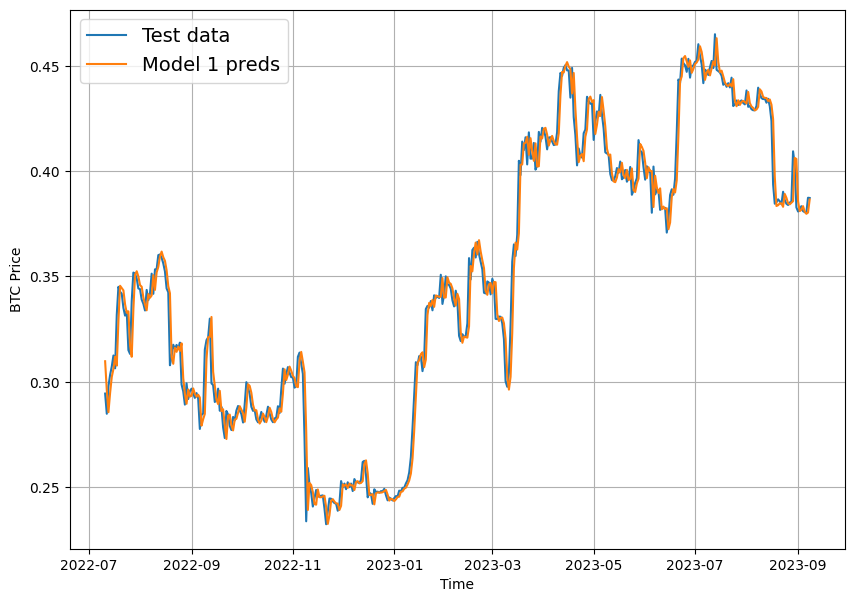

In [183]:
# Let's plot our model 1 predictions
offset= 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:],
                 start=offset,
                 format="-",
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model 1 preds")

## Make multivariate time series dataset

In [184]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 #3 jan 2009
block_reward_2 = 25 #8 nov 2012
block_reward_3 = 12.5 #9 jul 2016
block_reward_4 = 6.25 #18 may 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-12-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [185]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [186]:
# Add in block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [187]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


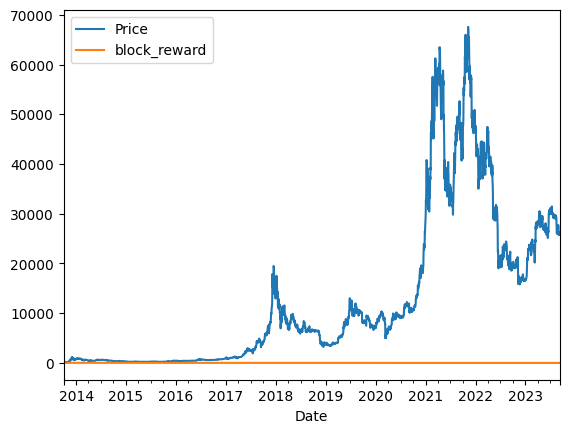

In [188]:
bitcoin_prices_block.plot();

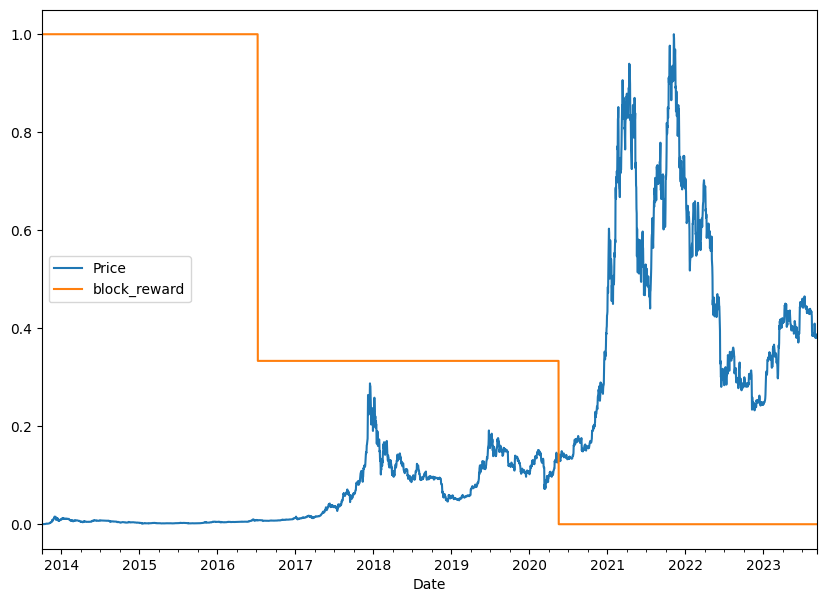

In [189]:
# Plot the block reward vs price oveer time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                   columns=bitcoin_prices_block.columns,
                                                   index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

### Making a windowed dataset with pandas
Using the pandas.DataFrame.shift()

In [190]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [191]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()
bitcoin_prices_windowed["block_reward"] = minmax_scale(bitcoin_prices_windowed["block_reward"])
# Add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in window_size
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,1.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,1.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,1.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,1.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,1.0,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,1.0,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,1.0,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,1.0,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset
directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [192]:
# Create X(windows) and y(horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,1.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,1.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,1.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,1.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,1.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [193]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2898, 2898, 725, 725)

## Model 6: Dense(multivariate time series)

In [194]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name= "model_6_dense_multivariate")

# Compile the model
model_6.compile(loss="mae",
                optimizer="adam")

# fit the model
model_6.fit(X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=128,
            verbose=1,
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
23/23 [==============================] - 2s 33ms/step - loss: 6236.1650 - val_loss: 2095.8718
Epoch 2/100
23/23 [==============================] - 0s 20ms/step - loss: 859.7602 - val_loss: 998.2441
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 380.6418 - val_loss: 1186.2036
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 347.4764 - val_loss: 1022.2571
Epoch 5/100
23/23 [==============================] - 0s 20ms/step - loss: 330.7577 - val_loss: 913.3818
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 328.7403 - val_loss: 963.7883
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 323.3728 - val_loss: 967.1277
Epoch 8/100
23/23 [==============================] - 0s 19ms/step - loss: 315.1481 - val_loss: 876.5475
Epoch 9/100
23/23 [==============================] - 0s 4ms/step - loss: 306.8687 - val_loss: 943.2632
Epoch 10/100
23/23 [==============================] - 0s 5ms/step

In [195]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

23/23 [==============================] - 0s 2ms/step - loss: 749.9804


749.9804077148438

In [196]:
# Load in thr best performing model[
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

23/23 [==============================] - 0s 2ms/step - loss: 692.0714


692.0714111328125

In [197]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

23/23 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([45044.066, 46687.805, 48213.273, 47864.633, 47365.785, 48153.14 ,
       47487.65 , 43234.953, 40544.65 , 42939.29 ], dtype=float32)>

In [198]:
# Evaluate predictions to get evaluate metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 692.07135,
 'mape': 2.1140137,
 'mase': 1.0217828,
 'mse': 1182944.6,
 'rmse': 1087.6326}

### Fomating windows and horizons using `tf.timeseries_dataset_from_array`

In [199]:
full_windows, full_labels= make_windows_horizon(x=prices, horizon=HORIZON, window_size=WINDOW_SIZE)
len(full_windows), len(full_labels)

(3623, 3623)

In [200]:
_# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: 123.033
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: 124.049
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: 125.96116


For most of models we used WINDOW_SIZE=7, but is there a better window size?
## Setup a series of experiments to find whether or not there's a better window size.
For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12

In [201]:
# Modelling experiments in loop
WINDOW_SIZE = 2
HORIZON = 1

# Initialize an empty dictionary to store model results
model_results = {}

for i in range(11):

  # make windows data
  make_windows_horizon(x=prices, horizon=HORIZON, window_size=WINDOW_SIZE)

  # get the windows and labels
  full_windows, full_labels= make_windows_horizon(x=prices, horizon=HORIZON, window_size=WINDOW_SIZE)

  # # View the first 3 windows/labels
  # for j in range(3):
  #   print(f"Window: {full_windows[j]} -> Label: {full_labels[j]}")


  # spliting to train and test sets
  train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

  # create the model
  model = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(HORIZON, activation="linear")
  ],name=f"model_{i}_dense")

  # compile the model
  model.compile(optimizer="adam",
                metrics=["mae","mse"],
                loss="mae")

  print(f"\n Training model: {i} with Window_size: {WINDOW_SIZE} and Horizon: 1")

  # fit the model
  model.fit(train_windows,train_labels,
            epochs=50,
            validation_data=(test_windows,test_labels),
            verbose=0,
            batch_size=128,
            callbacks=[create_model_checkpoint(model.name)])

  print(f"Model {i} trained")

  print(f"Evaluating model...")
  tf.keras.models.load_model(f"model_experiments/model_{i}_dense")
  print(model.evaluate(test_windows, test_labels), "\n")

  print(f"Making predictions with model {i}")
  # Make predictions
  preds = make_preds(model, test_windows)

  # Evaluate predictions
  results_model = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred =preds)
  # Calculate and store model evaluation results in the dictionary
  model_results[f"model_{i}_WS({WINDOW_SIZE})"] = results_model
  print(f"Results model {i}: \n {results_model}")
  print("----------\n")
  WINDOW_SIZE += 1


 Training model: 0 with Window_size: 2 and Horizon: 1
Model 0 trained
Evaluating model...
23/23 [==============================] - 0s 2ms/step - loss: 699.1946 - mae: 699.1946 - mse: 1220796.7500
[699.194580078125, 699.194580078125, 1220796.75] 

Making predictions with model 0
23/23 [==============================] - 0s 1ms/step
Results model 0: 
 {'mae': 699.1947, 'mape': 2.1435819, 'mase': 1.0292562, 'mse': 1220796.6, 'rmse': 1104.8966}
----------


 Training model: 1 with Window_size: 3 and Horizon: 1
Model 1 trained
Evaluating model...
23/23 [==============================] - 0s 3ms/step - loss: 704.0537 - mae: 704.0537 - mse: 1186545.5000
[704.0537109375, 704.0537109375, 1186545.5] 

Making predictions with model 1
23/23 [==============================] - 0s 2ms/step
Results model 1: 
 {'mae': 704.0537, 'mape': 2.1490188, 'mase': 1.0364089, 'mse': 1186545.4, 'rmse': 1089.2866}
----------


 Training model: 2 with Window_size: 4 and Horizon: 1
Model 2 trained
Evaluating model...


In [202]:
# Convert the dictionary to a DataFrame
model_results_df = pd.DataFrame.from_dict(model_results, orient='index')

In [203]:
model_results_df

,mae,mape,mase,mse,rmse
model_0_WS(2),699.194702,2.143582,1.029256,1220796.625,1104.896606
model_1_WS(3),704.053711,2.149019,1.036409,1186545.375,1089.286621
model_2_WS(4),700.350159,2.137906,1.030957,1230845.750,1109.434814
model_3_WS(5),791.000061,2.459134,1.167842,1395034.375,1181.115723
model_4_WS(6),701.817261,2.142772,1.036172,1210220.875,1100.100342
model_5_WS(7),736.707336,2.262916,1.087684,1272282.000,1127.954712
model_6_WS(8),842.182922,2.610325,1.243409,1471301.500,1212.972168
model_7_WS(9),706.991150,2.170056,1.043810,1235229.500,1111.408813
model_8_WS(10),766.857056,2.356087,1.133138,1400472.875,1183.415771
model_9_WS(11),851.010864,2.663677,1.257487,1556841.750,1247.734619


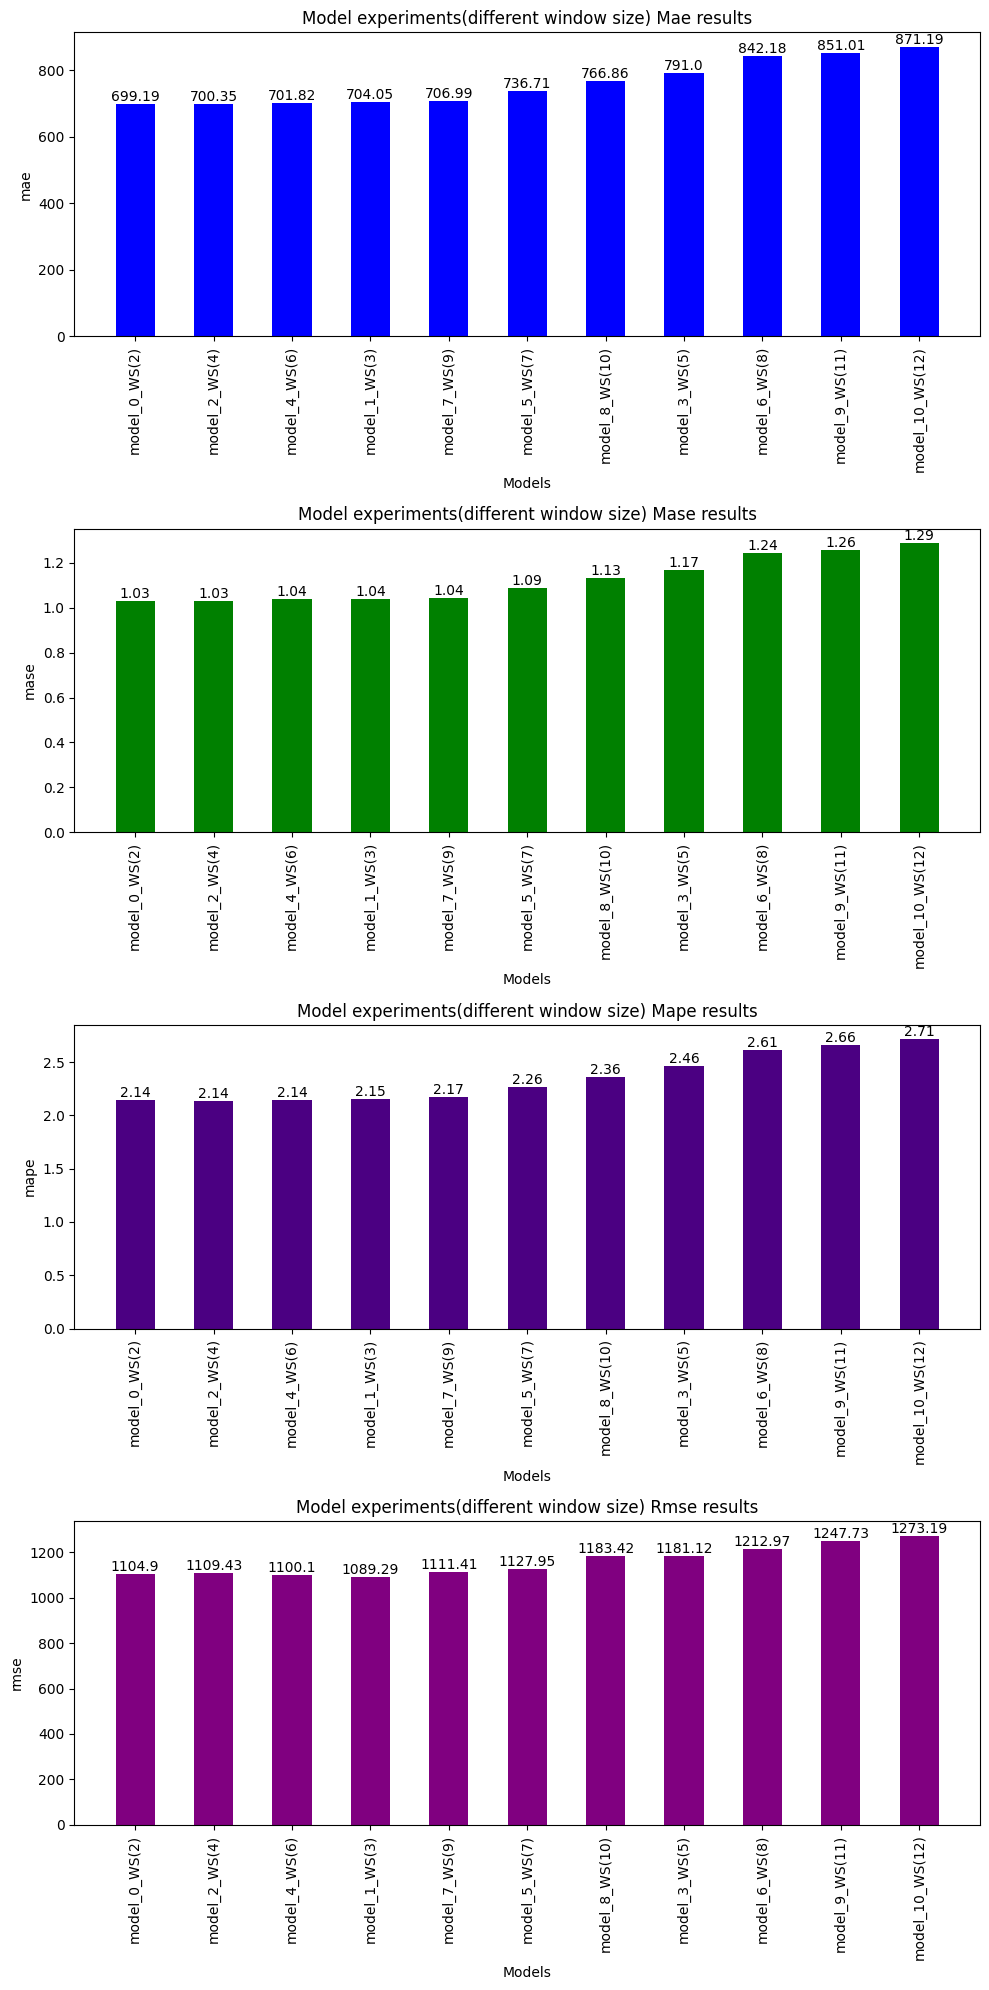

In [204]:
import matplotlib.pyplot as plt

# Define the metrics and corresponding colors
metrics = ["mae", "mase", "mape", "rmse"]
colors = ["blue", "green", "indigo", "purple"]

# Sort the DataFrame by the metric in ascending order
sorted_model_results_df = model_results_df.sort_values(by=metrics[0])  # Change metrics[0] to the metric you want to use for sorting


# Create a single column of subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(10,20))

# Iterate through metrics
for i, metric in enumerate(metrics):
    ax = axes[i]
    plot_metric = ax.bar(sorted_model_results_df.index, sorted_model_results_df[metric], color=colors[i], width=0.5)
    ax.set_xlabel("Models")
    ax.set_ylabel(metric)
    ax.set_xticks(model_results_df.index)
    ax.set_xticklabels(model_results_df.index, rotation=90)
    ax.set_title(f"Model experiments(different window size) {metric.capitalize()} results")

    # Annotate the bars with their values
    for bar in plot_metric:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()



It's seen that WINDOW_SIZE 3 works best on all evaluation metrics

## Make prediction intervals for future forecasts.
To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.

In [205]:
HORIZON = 1
WINDOW_SIZE = 3

### Constructing and fitting and ensemble of models (using different loss functions)

In [206]:
# Create dataset
# Add windowed columns
bitcoin_prices_ensemble = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_ensemble[f"Price+ {i+1}"] = bitcoin_prices_ensemble["Price"].shift(periods=i+1)
bitcoin_prices_ensemble.dropna().head()

# Make features and labels
X = bitcoin_prices_ensemble.dropna().drop("Price", axis=1)
y = bitcoin_prices_ensemble.dropna()["Price"]

# MAke train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)


(2901, 2901, 726, 726)

In [207]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [208]:
def get_ensemble_models(horizon=HORIZON,
                         train_data=train_dataset,
                         test_data=test_dataset,
                         num_iter=10,
                         num_epochs=1000,
                         loss_fns=["mae","mse" ,"mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE, RMSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae","mse" ,"mape"])
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing : {loss_function} for {num_epochs} epochs")

      # Construct a simple model (similar to model 1)
      model  = tf.keras.Sequential([
        # Initializer dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal" ,activation ="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # compile the model with current loss function
      model.compile(loss=loss_function,
                    optimizer="adam",
                    metrics=["mae", "mse"])

      # fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [209]:
%%time
# Get list of trained ensemle model
ensemble_model = get_ensemble_models(num_iter=5,
                                     num_epochs=1000)

Optimizing model by reducing : mae for 1000 epochs

Epoch 511: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 611: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing : mse for 1000 epochs

Epoch 734: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 834: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing : mape for 1000 epochs

Epoch 245: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 358: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 458: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing : mae for 1000 epochs

Epoch 693: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing : mse for 1000 epochs

Epoch 272: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 372: ReduceLROnPl

In [210]:
len(ensemble_model)

15

In [211]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds= []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [212]:
# Create a list of ensemble predictions
# Turn off all warnings except for errors
%%time
tf.get_logger().setLevel('ERROR')

ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_model,
                                     data=test_dataset);
ensemble_preds;

1/1 [==============================] - 0s 45ms/step
CPU times: user 883 ms, sys: 21.8 ms, total: 905 ms
Wall time: 989 ms


<tf.Tensor: shape=(15, 726), dtype=float32, numpy=
array([[45916.14 , 45019.59 , 46842.89 , ..., 25763.783, 25733.021,
        26162.514],
       [46001.254, 45031.11 , 46840.8  , ..., 25729.732, 25715.701,
        26183.676],
       [46053.977, 44967.73 , 47039.97 , ..., 25734.574, 25714.652,
        26218.424],
       ...,
       [46005.242, 45101.254, 46828.695, ..., 25768.496, 25749.822,
        26193.186],
       [45975.035, 44784.473, 47183.285, ..., 25760.408, 25719.709,
        26213.318],
       [46079.41 , 44762.19 , 47167.266, ..., 25699.77 , 25682.773,
        26235.898]], dtype=float32)>

In [213]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)

ensemble_results

{'mae': array([676.43335, 688.9087 , 680.6277 , 699.958  , 681.5057 , 683.0104 ,
        682.42816, 698.7863 , 683.09436, 692.759  , 691.1861 , 682.8487 ,
        687.60626, 689.56976, 682.4919 ], dtype=float32),
 'mape': array([2.0684018, 2.0930064, 2.072556 , 2.129907 , 2.0832732, 2.083901 ,
        2.1006126, 2.1387675, 2.0840642, 2.117376 , 2.1068382, 2.0802908,
        2.0960374, 2.1062453, 2.085184 ], dtype=float32),
 'mase': 1.0109333,
 'mse': array([1153689.2, 1170525.1, 1137427.9, 1211782.1, 1147835.8, 1140599.8,
        1139970.5, 1181131.9, 1135839.6, 1200352.6, 1168637.1, 1141412. ,
        1176569.2, 1141945.6, 1140871. ], dtype=float32),
 'rmse': array([1074.0992, 1081.9081, 1066.5026, 1100.8097, 1071.371 , 1067.9886,
        1067.694 , 1086.7988, 1065.7577, 1095.6061, 1081.0352, 1068.3689,
        1084.6978, 1068.6185, 1068.1156], dtype=float32)}

In [214]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([45992.883, 44927.18 , 46992.65 , 48118.664, 47709.355, 47186.727,
       48200.32 , 47215.367, 43223.48 , 40974.066], dtype=float32)>

In [215]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([46034.04 , 44956.37 , 47039.97 , 48173.01 , 47743.883, 47181.098,
       48253.777, 47240.2  , 43224.152, 41006.668], dtype=float32)

In [216]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 678.3013,
 'mape': 2.0686588,
 'mase': 0.9984998,
 'mse': 1141449.4,
 'rmse': 1068.3864}

In [217]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 679.65076,
 'mape': 2.0726163,
 'mase': 1.0004864,
 'mse': 1143409.6,
 'rmse': 1069.3033}

### Plotting the predictions interval(uncertainity estimates) of ensemble model

So far we've been making point predictions with our model.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussain/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To get the prediction interval upper and lower bounds, add and substract the value obtained in (3) to the mean/median of the predictions made in (1)

In [218]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): #1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply ultiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the predictions interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [219]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower[:10], upper[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([45758.188, 44678.445, 46635.12 , 47744.51 , 47485.36 , 47037.344,
        47995.5  , 46962.47 , 42425.742, 40318.68 ], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([46227.58 , 45175.914, 47350.176, 48492.816, 47933.35 , 47336.11 ,
        48405.14 , 47468.266, 44021.22 , 41629.453], dtype=float32)>)

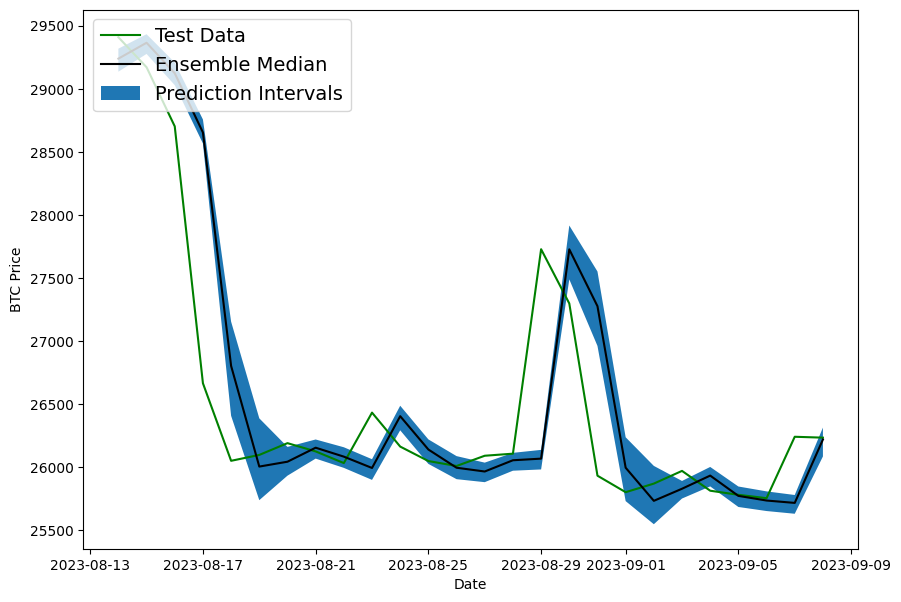

In [220]:
# Get the median/mean values of our ensemble preds
ensemble_median =  np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction interval (where the prediction fall between)
offset = 700
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between of matplotlib
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

### Make prediction into future

In [221]:
# How many timestamps to predict in the future?
INTO_FUTURE = 14

To make predictions into the future we want to function which:

1. Takes as input:
 * a list of values (Bitcoin historical data)
 * a trained model (such as `model_8`)
 * a window into the future to predict(our `INTO_FUTURE` variable)
 * the window size a model was trained on(`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on.
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full on predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [222]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after value ends.

  Returns future forecasts as a list of floats.
  """
   # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast  = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # predict on the last window then append it again and again(model will start make forecast on its own forecasts)
    # future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    future_pred= make_ensemble_preds(ensemble_models=ensemble_model,
                                     data=(tf.expand_dims(last_window, axis=0)))

    print(f"Predicting on :\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get window_size most recent preds(model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [223]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,1.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,1.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,1.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,1.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [224]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=full_labels,
                                        model=ensemble_model,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 49ms/step
Predicting on :
 [25753.236328 26240.195313 26233.162109] -> Prediction: [25782.834 25736.73  25703.37  25712.494 25635.35  25753.803 25735.033
 25705.566 25690.9   25762.1   25721.068 25721.984 25795.111 25704.428
 25666.072]

1/1 [==============================] - 0s 27ms/step
Predicting on :
 [25795.11132812 25704.42773438 25666.07226562] -> Prediction: [25759.928 25760.518 25764.143 25737.469 25684.545 25797.887 25764.086
 25708.385 25779.06  25656.318 25747.469 25786.754 25786.508 25755.355
 25745.602]

1/1 [==============================] - 0s 19ms/step
Predicting on :
 [25786.5078125  25755.35546875 25745.6015625 ] -> Prediction: [25758.697 25751.162 25752.053 25724.271 25676.238 25787.723 25760.785
 25679.13  25763.953 25666.365 25731.564 25774.105 25781.037 25749.074
 25726.871]

1/1 [==============================] - 0s 18ms/step
Predicting on :
 [25781.03710938 25749.07421875 25726.87109375] -> Prediction: [25752.807 25746.

In [225]:
future_forecast[:5]

[array([25782.834, 25736.73 , 25703.37 , 25712.494, 25635.35 , 25753.803,
        25735.033, 25705.566, 25690.9  , 25762.1  , 25721.068, 25721.984,
        25795.111, 25704.428, 25666.072], dtype=float32),
 array([25759.928, 25760.518, 25764.143, 25737.469, 25684.545, 25797.887,
        25764.086, 25708.385, 25779.06 , 25656.318, 25747.469, 25786.754,
        25786.508, 25755.355, 25745.602], dtype=float32),
 array([25758.697, 25751.162, 25752.053, 25724.271, 25676.238, 25787.723,
        25760.785, 25679.13 , 25763.953, 25666.365, 25731.564, 25774.105,
        25781.037, 25749.074, 25726.871], dtype=float32),
 array([25752.807, 25746.955, 25747.275, 25718.582, 25670.297, 25782.91 ,
        25753.   , 25675.188, 25759.402, 25658.916, 25727.773, 25769.492,
        25776.354, 25742.21 , 25722.41 ], dtype=float32),
 array([25747.951, 25741.955, 25742.545, 25714.168, 25665.758, 25778.096,
        25748.766, 25670.932, 25754.723, 25654.072, 25722.922, 25764.725,
        25771.314, 25737.842

In [226]:
future_forecast_median = np.median(future_forecast, axis=0)[:14]
future_forecast_mean= np.mean(future_forecast, axis=0)[:14]

In [227]:
len(future_forecast_median), len(future_forecast_mean)

(14, 14)

In [228]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") #return a date range between start and end date

In [229]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2023-09-08 00:00:00')

In [230]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)

next_time_steps

array(['2023-09-09', '2023-09-10', '2023-09-11', '2023-09-12',
       '2023-09-13', '2023-09-14', '2023-09-15', '2023-09-16',
       '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20',
       '2023-09-21', '2023-09-22'], dtype='datetime64[D]')

In [231]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast_median = np.insert(future_forecast_median, 0, prices[-1])
future_forecast_mean = np.insert(future_forecast_mean, 0, prices[-1])
len(next_time_steps), len(future_forecast_median), len(future_forecast_mean)

(15, 15, 15)

In [232]:
next_time_steps, future_forecast_median

(array(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
        '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
        '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
        '2023-09-20', '2023-09-21', '2023-09-22'], dtype='datetime64[D]'),
 array([26233.162, 25735.525, 25729.512, 25725.086, 25701.646, 25648.355,
        25760.643, 25734.398, 25658.34 , 25737.24 , 25641.74 , 25710.45 ,
        25747.26 , 25758.887, 25720.37 ], dtype=float32))

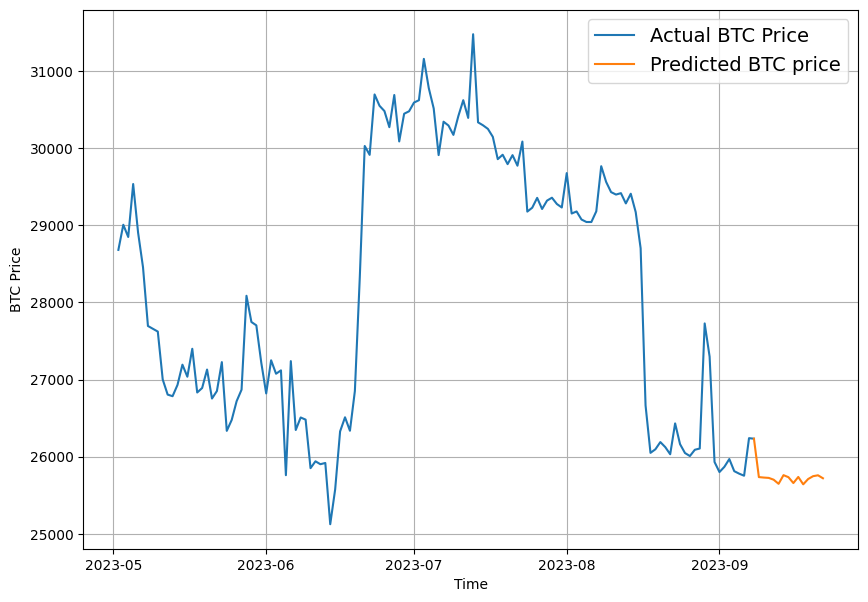

In [233]:
# Plot future prices prediction of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, prices, start=3500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast_median, format="-", label="Predicted BTC price")

plt.show()

Let's Create a DataFrame which keeps data prediction in future of ensemble model and other model and then compare with real price.

In [234]:
future_forecast_bitcoin = pd.DataFrame(columns=["ensemble_preds","dense_model_preds"])
future_forecast_bitcoin["ensemble_preds"] = future_forecast_median
future_forecast_bitcoin.index = next_time_steps
future_forecast_bitcoin.head()

,ensemble_preds,dense_model_preds
2023-09-08,26233.162109,NaN
2023-09-09,25735.525391,NaN
2023-09-10,25729.511719,NaN
2023-09-11,25725.085938,NaN
2023-09-12,25701.646484,NaN


## Train models for future forecast
Training 2 simple models on full data and making future forecast from it.  

`model_0` : makes future predictions without retraining on predictions.  
`model_1` : makes future predictions with retraining on Predictions.

Plot both model's predictions

In [235]:
WINDOW_SIZE = 3
HORIZON = 1

### Get all the data

In [236]:
full_windows, full_labels= make_windows_horizon(x=prices, horizon=HORIZON, window_size=WINDOW_SIZE)

In [237]:
# Train model on entire data to make predicitons for the next day
X_all = full_windows
# Get labels
y_all = full_labels

len(X_all), len(y_all)

(3627, 3627)

In [238]:
X_all[:5], y_all[:5]

(array([[123.65499, 125.455  , 108.58483],
        [125.455  , 108.58483, 118.67466],
        [108.58483, 118.67466, 121.33866],
        [118.67466, 121.33866, 120.65533],
        [121.33866, 120.65533, 121.795  ]]),
 array([118.67466, 121.33866, 120.65533, 121.795  , 123.033  ]))

In [239]:
# Turn data into efficent running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### Model 0: Training

In [240]:
model_0 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

# Compile the model
model_0.compile(loss="mae",
                optimizer="adam")

# Fit the model on all of the data to make future forecasts
model_0.fit(dataset_all,
            epochs=100,
            verbose=0)

In [241]:
model_1 = tf.keras.models.clone_model(model_0)

model_1.compile(loss="mae",
                optimizer="adam")

# Fit the model on all of the data to make future forecasts
model_1.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions in future

In [242]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after value ends.

  Returns future forecasts as a list of floats.
  """
   # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast  = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # predict on the last window then append it again and again(model will start make forecast on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))

    print(f"Predicting on :\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get window_size most recent preds(model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [243]:
# How many timesteps to predict in the future?
INTO_FUTURE = 14

future_forecast = make_future_forecasts(values=y_all,
                      model=model_0,
                      into_future=INTO_FUTURE,
                      window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 56ms/step
Predicting on :
 [25753.236328 26240.195313 26233.162109] -> Prediction: 26142.39453125

1/1 [==============================] - 0s 22ms/step
Predicting on :
 [26240.195313   26233.162109   26142.39453125] -> Prediction: 26057.197265625

1/1 [==============================] - 0s 18ms/step
Predicting on :
 [26233.162109   26142.39453125 26057.19726562] -> Prediction: 25967.59765625

1/1 [==============================] - 0s 19ms/step
Predicting on :
 [26142.39453125 26057.19726562 25967.59765625] -> Prediction: 25879.849609375

1/1 [==============================] - 0s 26ms/step
Predicting on :
 [26057.19726562 25967.59765625 25879.84960938] -> Prediction: 25791.78125

1/1 [==============================] - 0s 19ms/step
Predicting on :
 [25967.59765625 25879.84960938 25791.78125   ] -> Prediction: 25704.25

1/1 [==============================] - 0s 18ms/step
Predicting on :
 [25879.84960938 25791.78125    25704.25      ] -> Prediction: 

Make future predictions with retraining on predictions

In [244]:
# 1. Create function to make predictions into the future
def make_future_forecasts_retrained(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after value ends.

  Returns future forecasts as a list of floats.
  """
   # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast  = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # predict on the last window then append it again and again(model will start make forecast on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))

    print(f"Predicting on :\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get window_size most recent preds(model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

     # Retrain the model
    model.fit(x=tf.expand_dims(last_window, axis=0),
              y=tf.expand_dims((tf.squeeze(future_pred)), axis=0),
              epochs=10,
              verbose=0)

    print(f"Model retrained on Predictions {_}")
  return future_forecast

In [245]:
# Future forecast retrained
future_forecast_retrained = make_future_forecasts_retrained(values=y_all,
                      model=model_1,
                      into_future=INTO_FUTURE,
                      window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 48ms/step
Predicting on :
 [25753.236328 26240.195313 26233.162109] -> Prediction: 26106.87890625

Model retrained on Predictions 0
1/1 [==============================] - 0s 26ms/step
Predicting on :
 [26240.195313   26233.162109   26106.87890625] -> Prediction: 25902.771484375

Model retrained on Predictions 1
1/1 [==============================] - 0s 29ms/step
Predicting on :
 [26233.162109   26106.87890625 25902.77148438] -> Prediction: 26623.5859375

Model retrained on Predictions 2
1/1 [==============================] - 0s 27ms/step
Predicting on :
 [26106.87890625 25902.77148438 26623.5859375 ] -> Prediction: 26673.375

Model retrained on Predictions 3
1/1 [==============================] - 0s 33ms/step
Predicting on :
 [25902.77148438 26623.5859375  26673.375     ] -> Prediction: 26239.828125

Model retrained on Predictions 4
1/1 [==============================] - 0s 26ms/step
Predicting on :
 [26623.5859375 26673.375     26239.828125 ] 

In [246]:
future_forecast[:5], future_forecast_retrained[:5]

([26142.395, 26057.197, 25967.598, 25879.85, 25791.781],
 [26106.879, 25902.771, 26623.586, 26673.375, 26239.828])

In [247]:
# Insert last timestep/final price so the graph doesn't look messed
future_forecast = np.insert(future_forecast, 0, prices[-1])
future_forecast_retrained = np.insert(future_forecast_retrained, 0, prices[-1])
len(next_time_steps), len(future_forecast), len(future_forecast_retrained)

(15, 15, 15)

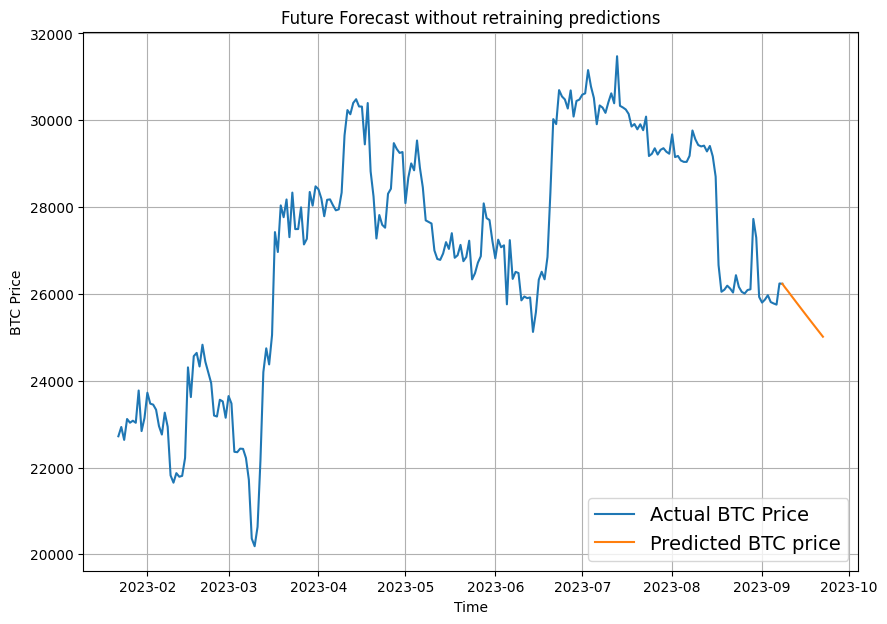

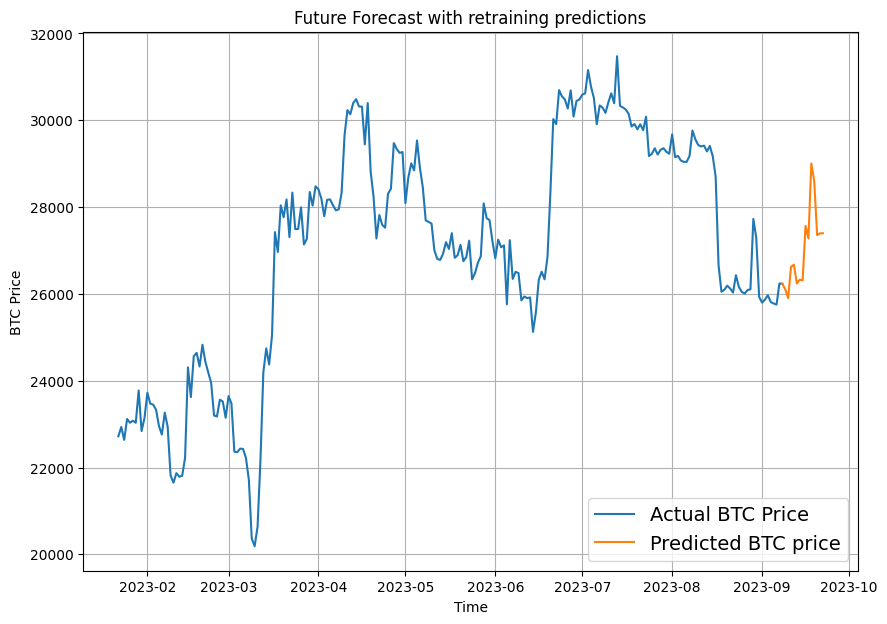

In [248]:
# Plot future prices prediction of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, prices, start=3400, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC price")
plt.title("Future Forecast without retraining predictions")

plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, prices, start=3400, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast_retrained, format="-", label="Predicted BTC price")
plt.title("Future Forecast with retraining predictions")

plt.show()


From the plot it is seen the model which is not retrained fails in forecasting

In [249]:
future_forecast_bitcoin["dense_retrained_preds"] = future_forecast_retrained
future_forecast_bitcoin.head()

,ensemble_preds,dense_model_preds,dense_retrained_preds
2023-09-08,26233.162109,NaN,26233.162109
2023-09-09,25735.525391,NaN,26106.878906
2023-09-10,25729.511719,NaN,25902.771484
2023-09-11,25725.085938,NaN,26623.585938
2023-09-12,25701.646484,NaN,26673.375000


Show time! Let's take real prices of the new dates from https://finance.yahoo.com/

In [250]:
# Get prices from
real_price = [26233.16, 25895.68, 25832.23, 25162.65, 25833.34, 26228.32, 26539.67, 26608.69, 26568.28, 26534.19, 26754.28, 27211.12, 0.0 , 26785.25, 0.0]
future_forecast_bitcoin["real_price"] = real_price

In [251]:
# round off to prettify
future_forecast_bitcoin["dense_retrained_preds"] = future_forecast_bitcoin["dense_retrained_preds"].apply(lambda x: float(f"{x:.2f}"))
future_forecast_bitcoin["ensemble_preds"] = future_forecast_bitcoin["ensemble_preds"].apply(lambda x: float(f"{x:.2f}"))
future_forecast_bitcoin.head()

,ensemble_preds,dense_model_preds,dense_retrained_preds,real_price
2023-09-08,26233.16,NaN,26233.16,26233.16
2023-09-09,25735.53,NaN,26106.88,25895.68
2023-09-10,25729.51,NaN,25902.77,25832.23
2023-09-11,25725.09,NaN,26623.59,25162.65
2023-09-12,25701.65,NaN,26673.38,25833.34


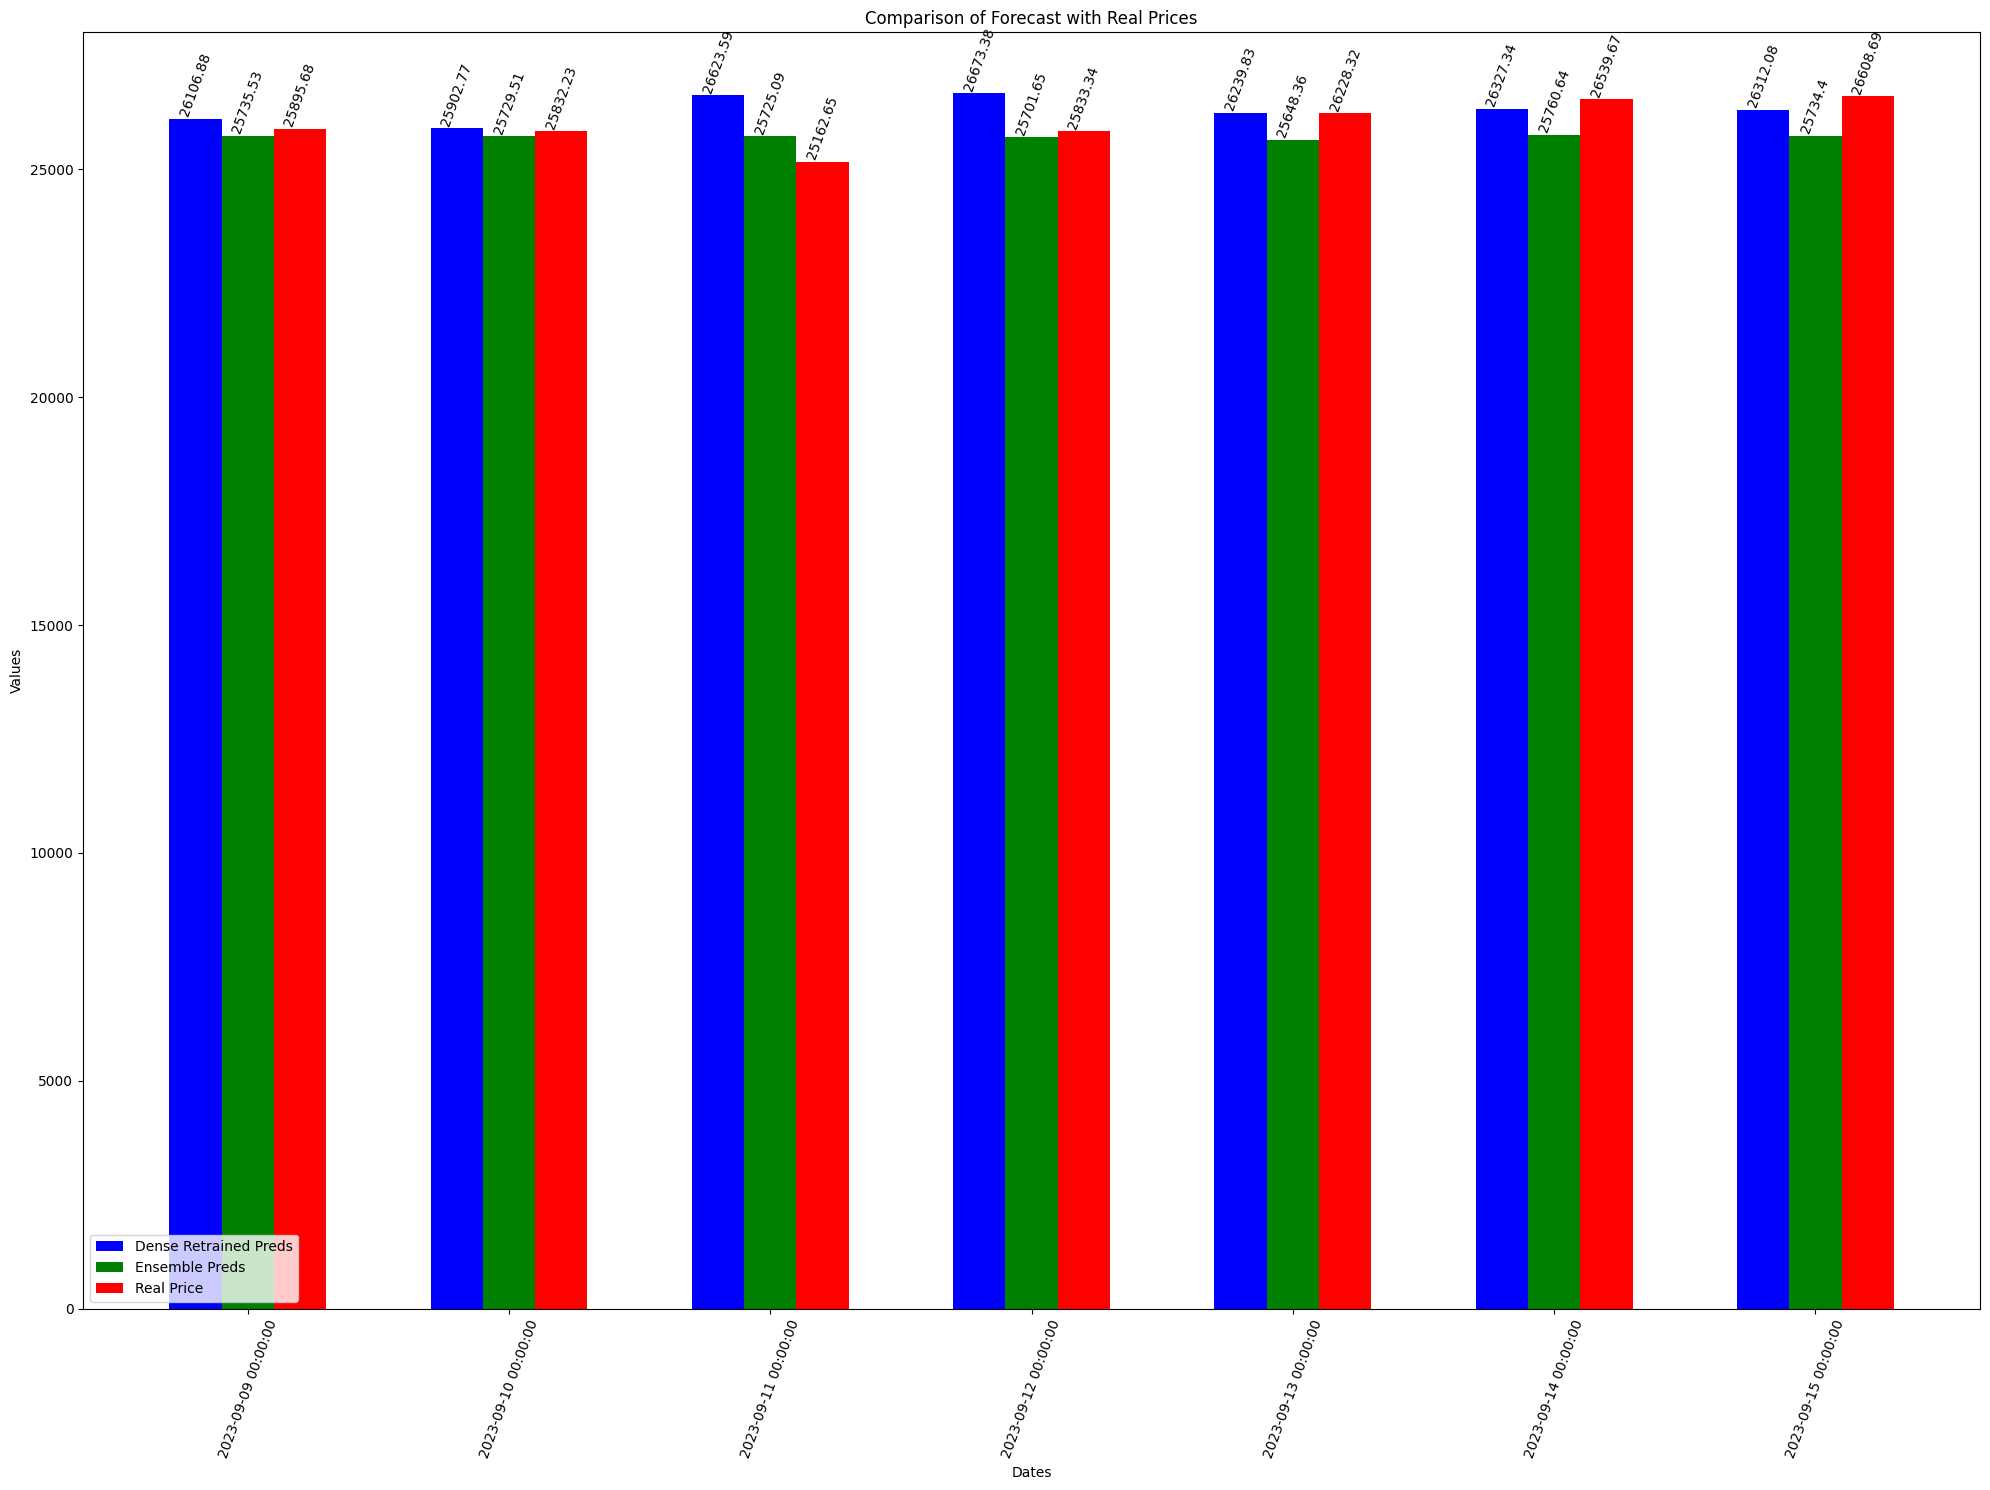

In [253]:
import matplotlib.pyplot as plt

# Extract the dates and values
dates = future_forecast_bitcoin.index[1:8]  # Skip the first value and take the next 7
dense_retrained_preds = future_forecast_bitcoin["dense_retrained_preds"][1:8]
ensemble_preds = future_forecast_bitcoin["ensemble_preds"][1:8]
real_price = future_forecast_bitcoin["real_price"][1:8]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 15))

# Plot the three bars
bar_width = 0.2
index = range(len(dates))
plt.bar(index, dense_retrained_preds, bar_width, label='Dense Retrained Preds', color='b', align='center')
plt.bar([i + bar_width for i in index], ensemble_preds, bar_width, label='Ensemble Preds', color='g', align='center')
plt.bar([i + 2 * bar_width for i in index], real_price, bar_width, label='Real Price', color='r', align='center')

# Set the x-axis labels as dates and rotate them by 70 degrees
plt.xticks([i + bar_width for i in index], dates, rotation=70)

# Add values on top of the bars with smaller font size
for i, v in enumerate(dense_retrained_preds):
    ax.text(i, v + 10, str(round(v, 2)), ha='center', va='bottom', fontsize=10, rotation=70)
for i, v in enumerate(ensemble_preds):
    ax.text(i + bar_width, v + 10, str(round(v, 2)), ha='center', va='bottom', fontsize=10, rotation=70)
for i, v in enumerate(real_price):
    ax.text(i + 2 * bar_width, v + 10, str(round(v, 2)), ha='center', va='bottom', fontsize=10, rotation=70)

# Move the legend to the bottom-left
ax.legend(loc='lower left')

# Set labels and title
plt.xlabel('Dates')
plt.ylabel('Values')
plt.title('Comparison of Forecast with Real Prices')

# Show the plot
plt.tight_layout()
plt.show()


Cool! It is very unlikely the model will be correct or have high accuracy becasue a model cannot predict anything in the future outside of the distribution it was trained on.

In turn, highly unlikely price movements (based on historical movements), upward or downward will likely never be part of a forecast.

However, as we've seen, despite their unlikeliness, these events can have huuuuuuuuge impacts to the performance of our models.

